Well, hopefully I will be able to make this work. 

In [1]:
import sys
sys.path.append('/home/keeganfl/Desktop/Work_Fall_2021/Fall_2021_Work_journal/tools/')

In [2]:
# import plastid
# data structure for mapping read alignments to genomic positions
from plastid import BAMGenomeArray, VariableFivePrimeMapFactory, \
                        GTF2_TranscriptAssembler, GFF3_TranscriptAssembler, \
                        Transcript, ThreePrimeMapFactory, CenterMapFactory
from plastid.plotting.plots import *
import numpy as np
import os
from Bio import SeqIO
import numpy
import math
import pandas as pd
from scipy import stats
import keegan_analysis_tools as kat
from statsmodels.nonparametric.smoothers_lowess import lowess
import warnings
import matplotlib.pyplot as plt
%matplotlib inline
import csv
from matplotlib.pyplot import figure
from scipy.sparse.linalg import lsqr
from multiprocess import Pool
from tqdm import tqdm

## define functions

In [3]:
def low_density(lamb,a,I = 10):
    '''
    A function that calculates the particle density along a transcript from a set of elongation rates
    inferred from ribosome profiling. This function assumes that elongation is in a low density regime
    (e.g. initiation limiting)
    '''
    Jl = (a*(lamb[0]-a))/(lamb[0] + (I-1)*a)
    pl = 1/(2*I) + (Jl*(I-1))/(2*I*lamb) - np.sqrt((1/(2*I) + (Jl*(I-1))/(2*I*lamb))**2 - Jl/(I*lamb))
    return(pl) 

def high_density(lamb,B,I = 10):
    '''
    A function that calculates the particle density along a transcript from a set of elongation rates
    inferred from ribosome profiling. This function assumes that elongation is in a high density regime
    (e.g. termination limiting)
    '''
    JR = (B*(lamb[-1]-B))/(lamb[-1] + (I-1)*B)
    pR = 1/(2*I) + (JR*(I-1))/(2*I*lamb) + np.sqrt((1/(2*I) + (JR*(I-1))/(2*I*lamb))**2 - JR/(I*lamb))
    return(pR) 

def maximum_current(lamb,a,B,I = 10):
    '''
    A function that calculates the particle density along a transcript from a set of elongation rates
    inferred from ribosome profiling. This function assumes that elongation is in a maximum current regime
    (e.g. elongation limiting)
    '''
    Jmax = min(lamb)/((1+np.sqrt(I))**2)
    flip = np.where(lamb == np.amin(lamb))[0][0]
    pR = 1/(2*I) + (Jmax*(I-1))/(2*I*lamb[0:flip]) + np.sqrt((1/(2*I) + (Jmax*(I-1))/(
        2*I*lamb[0:flip]))**2 - Jmax/(I*lamb[0:flip]))
    pl = 1/(2*I) + (Jmax*(I-1))/(2*I*lamb[flip:]) - np.sqrt((1/(2*I) + (Jmax*(I-1))/(
        2*I*lamb[flip:]))**2 - Jmax/(I*lamb[flip:]))
    p = np.concatenate((pR,pl))
    return(p) 

def make_mc(arr_c, position, a, B, I = 10):
    '''
    This function purposefully induces elongation limitation at a certain point 
    '''
    lamb_c = copy.deepcopy(arr_c)
    Jmax = min(lamb_c)/((1+np.sqrt(I))**2)
    crit_a = ((lamb_c[0] - (I-1) * Jmax) / 2)*(1 - np.sqrt(1 - (4*lamb_c[0]*Jmax)/((lamb_c[0] - (I - 1)*Jmax)**2)))
    crit_B = ((lamb_c[-1] - (I-1) * Jmax) / 2)*(1 - np.sqrt(1 - (4*lamb_c[-1]*Jmax)/((lamb_c[-1] - (I - 1)*Jmax)**2)))
    mut_min = position
    while True:
        lamb_c[mut_min] = lamb_c[mut_min]*0.9 # It keeps doing this every run through. 
        Jmax = min(lamb_c)/((1+np.sqrt(I))**2)
        crit_a = ((lamb_c[0] - (I-1) * Jmax) / 2)*(1 - np.sqrt(1 - (4*lamb_c[0]*Jmax)/((lamb_c[0] - (I - 1)*Jmax)**2)))
        crit_B = ((lamb_c[-1] - (I-1) * Jmax) / 2)*(1 - np.sqrt(1 - (4*lamb_c[-1]*Jmax)/((lamb_c[-1] - (I - 1)*Jmax)**2)))
        if crit_a < a and crit_B < B:
            break
    p = maximum_current(lamb_c,a=a,B=B,I = 10)
    return p

def make_ld(lamb, a, B, I = 10):
    lamb_c = copy.deepcopy(lamb)# Create a copy of lamb to work on. 
    Jmax = min(lamb_c)/((1+np.sqrt(I))**2)
    crit_a = ((lamb_c[0] - (I-1) * Jmax) / 2)*(1 - np.sqrt(1 - (4*lamb_c[0]*Jmax)/((lamb_c[0] - (I - 1)*Jmax)**2)))
    crit_B = ((lamb_c[-1] - (I-1) * Jmax) / 2)*(1 - np.sqrt(1 - (4*lamb_c[-1]*Jmax)/((lamb_c[-1] - (I - 1)*Jmax)**2)))
    if a < crit_a and B > crit_B:
        p = low_density(lamb_c, a, I)
    else:
        while True:
            min_l = np.where(lamb_c == np.amin(lamb_c))[0][0]
            lamb_c[min_l] = lamb_c[min_l]*1.1 # It keeps doing this every run through. 
            Jmax = min(lamb_c)/((1+np.sqrt(I))**2)
            crit_a = ((lamb_c[0] - (I-1) * Jmax) / 2)*(1 - np.sqrt(1 - (4*lamb_c[0]*Jmax)/((lamb_c[0] - (I - 1)*Jmax)**2)))
            crit_B = ((lamb_c[-1] - (I-1) * Jmax) / 2)*(1 - np.sqrt(1 - (4*lamb_c[-1]*Jmax)/((lamb_c[-1] - (I - 1)*Jmax)**2)))
            if a < crit_a and B > crit_B:
                break
        p = low_density(lamb_c, a, I) 
    return p

# I would like to create a function that determines which density function to use, 
# outputs a message saying which one it used, and then calculates the density with the correct function. 

def get_density(lamb, a, B, I = 10, intermediates = False):
    lamb_c = copy.deepcopy(lamb)# Create a copy of lamb to work on. 
    Jmax = min(lamb_c)/((1+np.sqrt(I))**2)
    crit_a = ((lamb_c[0] - (I-1) * Jmax) / 2)*(1 - np.sqrt(1 - (4*lamb_c[0]*Jmax)/((lamb_c[0] - (I - 1)*Jmax)**2)))
    crit_B = ((lamb_c[-1] - (I-1) * Jmax) / 2)*(1 - np.sqrt(1 - (4*lamb_c[-1]*Jmax)/((lamb_c[-1] - (I - 1)*Jmax)**2)))
    if a < crit_a and B > crit_B:
        p = low_density(lamb_c, a, I)
        density = "LD"
    elif a > crit_a and B < crit_B:
        p = high_density(lamb_c, B, I)
        density = "HD"
    elif a < crit_a and B < crit_B:
        Jl = (a*(lamb[0]-a))/(lamb[0] + (I-1)*a)
        JR = (B*(lamb[-1]-B))/(lamb[-1] + (I-1)*B)
        sign = Jl - JR 
        if sign > 0:
            p = low_density(lamb_c, a, I)
            density = "LD"
        elif sign < 0:
            p = high_density(lamb_c, B, I)
            density = "HD"
    elif a > crit_a and B > crit_B:
        p = maximum_current(lamb_c, a, B, I)
        density = "MC"
    if intermediates == False:
        return p, density
    elif intermediates == True:
        return p, a, B, crit_a, crit_B, min(lamb_c), lamb_c[0]

What on earth am I drawing these samples from? I will use my gamma distribution but I should also just try a uniform ditribution like he told me too. 

## Test Out procedure

In [4]:
yal = np.array([0.873105,12.742887,11.868705,7.290501,2.947732,13.191317,18.065217,10.761338,12.256782,43.655271,27.766908,11.5934,13.467782,20.729213,15.457866,6.774457,24.054755,3.273828,2.421011,3.825033,6.1789,2.381281,2.731171,12.092041,6.931031,3.369468,6.805203,2.56164,5.629836,2.633629,1.687895,4.484785,8.925078,11.330577,4.831621,2.2137,5.212328,6.931031,9.842974,15.248268,13.038374,6.1789,2.59414,28.290812,18.435406,3.068376,4.905386,23.067893,9.778781,2.763046,25.704224,30.809857,6.703784,4.613579,6.195922,23.674943,22.833701,21.836112,15.300133,25.704224,30.600266,6.086927,18.742663,19.060335,30.600266,42.436218,43.655271,43.655271,43.655271,43.655271,14.280124,7.197183,2.941948,10.293453,7.017534,7.836654,7.302336,3.522505,3.973709,4.705271,2.806138,1.827067,6.120053,2.934272,3.935467,3.69921,5.546534,2.802641,5.273434,1.729427,4.02347,2.621351,3.844649,5.478976,3.904721,6.995706,4.078186,2.29385,9.469977,43.655271,6.086927,11.931669,3.871118,5.752224,8.584426,6.952456,3.587113,8.06136,14.510449,13.672459,30.809857,43.655271,16.910673,43.655271,43.655271,43.655271,43.655271,43.655271,21.118494,19.903713,18.36016,31.67774,15.511169,4.926877,7.947419,4.775201,4.84724,4.97043,2.996828,7.117467,4.052468,4.350328,3.897954,3.977223,2.609187,4.715135,29.593679,4.770137,7.891648,3.324641,5.285827,35.700311,9.996087,4.130614,6.703784,10.388543,8.734445,5.997652,18.664893,14.700128,28.290812,4.852469,22.491196,43.655271,12.60011,29.020898,7.782421,35.700311,9.430271,2.149183,2.46209,6.472287,4.005556,3.300249,3.729883,5.505801,2.215881,11.683738,6.111738,6.136752,4.418703,4.852469,5.553382,9.371332,17.435035,5.285827,4.296312,3.654134,3.956235,3.818539,11.330577,1.902004,5.950052,5.426103,1.000498,1.851889,28.469868,3.786397,5.880051,5.880051,9.757569,4.981439,6.974014,5.774376,13.969687,3.684062,21.836112,22.158814,19.729119,5.426103,14.013206,17.502876,15.196754,6.462987,37.17553,2.555818])

In [5]:
min(yal)

0.873105

In [6]:
np.sqrt(5.6)

2.3664319132398464

In [7]:
lamb = np.random.gamma(2.5,3,200) + 0.3

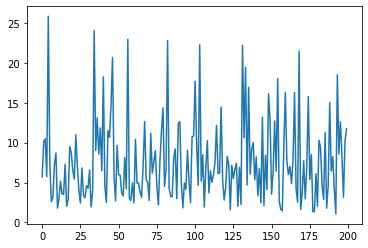

In [8]:
plt.plot(lamb)

In [9]:
p = get_density(yal, 0.17, 0.6)

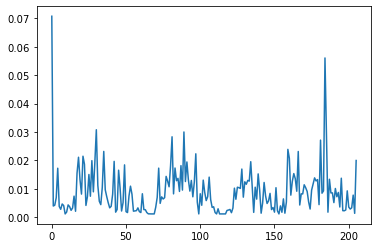

In [10]:
plt.plot(p[0])

In [11]:
prob_p = p[0]/sum(p[0])

In [14]:
pause_sites = np.random.randint(10, len(lamb)/2, 4)
lamb_m = copy.deepcopy(lamb)
for ps in pause_sites:
    lamb_m[ps] = lamb_m[ps]* np.random.uniform(0.00001, 0.002, 1)[0]

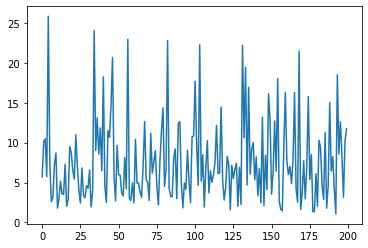

In [15]:
plt.plot(lamb)

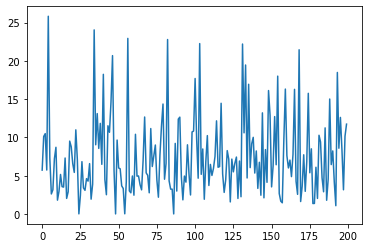

In [16]:
plt.plot(lamb_m)

## Draw random samples from your particle densities

In [17]:
# Equation I used to add noise in case I need it again. 
#math.e**(np.log(lamb_c) + np.random.normal(0, noise, length))

In [42]:
def get_all_intermediates(mean_lambda, sd, length, a, B = 2, read_density = 1):
    '''
    A function that simulates ribosome profiling data from a mutant and a control for a single gene. 
    
    mean_lambda: The mean elongation rate you for the simulated gene
    sd: The standard deviation of the elongation rates for your simulated gene
    length: The length of your simulated gene
    a: The initiation rate of your simulated gene
    B: The termination rate of your simulated gene
    read_density: how many reads should be extracted from your simulated gene per codon. 
    
    '''
    mean_sqr = np.sqrt(mean_lambda)
    sample_size = int(read_density * length)
    lamb_c = np.random.gamma(mean_sqr, sd, length)+0.3
    
    # Create a set of random pause sights in your mutant. 
    pause_sites = np.random.randint(10, length/2, 4)
    lamb_m = copy.deepcopy(lamb_c)
    for ps in pause_sites:
        lamb_m[ps] = lamb_m[ps]* np.random.uniform(0.1, 0.8, 1)[0]
    
    # simulate the reads for the control
    p_c, a_c, B_c, crit_a_c, crit_B_c, min_l_c, ini_l_c = get_density(lamb_c, a, B, intermediates = True)
    prob_c = p_c/sum(p_c)
    reads_c = np.zeros(length)
    for i in range(sample_size):
        x = numpy.random.choice(np.arange(0, len(prob_c)), p = prob_c)
        reads_c[x] = reads_c[x]+1

    # simulate the reads for the mutant assuming LD
    mu_a = a* np.random.uniform(0.25, 2, 1)[0]
    p_m, a_m, B_m, crit_a_m, crit_B_m, min_l_m, ini_l_m = get_density(lamb_m, mu_a, B, intermediates = True)
    prob_m = p_m/sum(p_m)
    reads_m = np.zeros(length)
    for i in range(sample_size):
        x = numpy.random.choice(np.arange(0, len(prob_m)), p = prob_m)
        reads_m[x] = reads_m[x]+1
    return reads_c, a_c, B_c, crit_a_c, crit_B_c, min_l_c, ini_l_c, reads_m, a_m, B_m, crit_a_m, crit_B_m, min_l_m, ini_l_m

# Create a function to automate the simulation process
def simulate_ribo_profiles(mean_lambda, sd, length, a, B = 2, read_density = 1):
    '''
    A function that simulates ribosome profiling data from a mutant and a control for a single gene. 
    
    mean_lambda: The mean elongation rate you for the simulated gene
    sd: The standard deviation of the elongation rates for your simulated gene
    length: The length of your simulated gene
    a: The initiation rate of your simulated gene
    B: The termination rate of your simulated gene
    read_density: how many reads should be extracted from your simulated gene per codon. 
    
    '''
    mean_sqr = np.sqrt(mean_lambda)
    sample_size = int(read_density * length)
    lamb_c = np.random.gamma(mean_sqr, sd, length)+0.3
    
    # Create a set of random pause sights in your mutant. 
    pause_sites = np.random.randint(10, length/2, 4)
    lamb_m = copy.deepcopy(lamb_c)
    for ps in pause_sites:
        lamb_m[ps] = lamb_m[ps]* np.random.uniform(0.1, 0.8, 1)[0]
    
    # simulate the reads for the control
    p_c = get_density(lamb_c, a, B)
    prob_c = p_c[0]/sum(p_c[0])
    reads_c = np.zeros(length)
    for i in range(sample_size):
        x = numpy.random.choice(np.arange(0, len(prob_c)), p = prob_c)
        reads_c[x] = reads_c[x]+1

    # simulate the reads for the mutant assuming LD
    mu_a = a* np.random.uniform(0.25, 2, 1)[0]
    p_m = get_density(lamb_m, mu_a, B)
    prob_m = p_m[0]/sum(p_m[0])
    reads_m = np.zeros(length)
    for i in range(sample_size):
        x = numpy.random.choice(np.arange(0, len(prob_m)), p = prob_m)
        reads_m[x] = reads_m[x]+1
    return reads_c, reads_m

In [49]:
# Create a large number of simulations
# I should probably try to run this in parallel
data_control = []
data_mutant = []
for i in range(200):
    length = numpy.random.randint(200,2500)
    alpha = numpy.random.uniform(0.004,0.02)
    x = simulate_ribo_profiles(5.6, 3, length, alpha, 2, 5)
    data_control.append(x[0])
    data_mutant.append(x[1])

## Calculate Smoothed Vector Arrays

In [50]:
# Define the maximum number of processors that can be used when creating the smoothed vector arrays
max_pool = 20

# get smoothed vector arrays for all of the control data.
with Pool(max_pool) as p:
    pool_control = list(
         tqdm(
            p.imap(kat.get_smoothed_vector_parallel,
                      data_control),
            total=len(data_control)
        )
    )    

100%|█████████████████████████████████████████| 200/200 [00:02<00:00, 75.10it/s]


In [51]:
# get smoothed vector arrays for all of the mutant data.
with Pool(max_pool) as p:
    pool_mutant = list(
        tqdm(
            p.imap(kat.get_smoothed_vector_parallel,
                       data_mutant),
            total=len(data_mutant)
        )
    )    

100%|█████████████████████████████████████████| 200/200 [00:02<00:00, 76.77it/s]


## Determine KS statistic for all transcripts

In [52]:
# Find the correlation between all of the controls and the samples.
# Note that many of the lowest values spring from very short transcripts or transcripts with few reads. 
ks_list = []
len_list = []
id_list = []
x = -1
for tr_m, tr_c, index in zip(data_mutant, data_control, list(range(len(data_mutant)))):
    # Only Calculate KS statistics for genes with decent length and read density
    x = x+1
    if len(tr_m) > 200 and sum(tr_m)/len(tr_m) > 0.15 and sum(tr_c)/len(tr_c) > 0.15:
        position = np.array(list(range(len(tr_m))))
        smoothed_vec_m, cumul_m = pool_mutant[index]
        smoothed_vec_c, cumul_c = pool_control[index]
        ks = max(abs(cumul_m - cumul_c))
        ks_list.append(ks)
        len_list.append(len(tr_m))
        id_list.append(x)
            
# reorganizing the lists into a dataframe. 
df_b = pd.DataFrame(list(zip(ks_list, len_list, id_list)))
df_b.columns = ["ks_stat", "gene_length", "id"]
#df_b.to_csv(save_path + "ks_table_" + samp_num + ".csv", index=False)
    
# Clear out unneeded lists
ks_list.clear()
len_list.clear()

Changed some elongation rates, but that change only matters if MC is changed. 

Just showing that the KS statistic works? 
Look at different initiation rates, start with decreasing by half.
Pick randomly and then decrease by a specific factor rather than a random factor. different levels, start with decreasing. 
Have pauses in the control and then reverse them. 
Experiment with doing different read densities. 


Text(0.5, 1.0, 'KS statistic of all simulated genes')

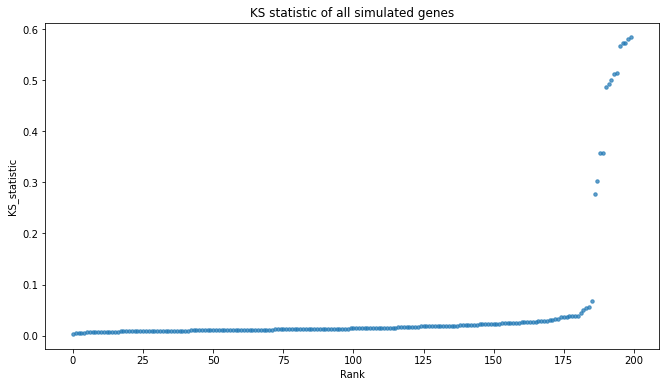

In [53]:
# Plot the KS values for each gene from lowest to highest. 
figure(figsize = (11,6))
plt.scatter(list(range(len(df_b["ks_stat"]))), sorted(df_b["ks_stat"]), s=12, alpha = 0.7)
plt.ylabel("KS_statistic")
plt.xlabel("Rank")
plt.title("KS statistic of all simulated genes")

In [54]:
def big_dif(diff_dist, data_mutant, data_control, figsize = (16,50), fontsize = 12, stat_name = "ks_stat ="):
    '''
    A function which creates a large graph showing the profile arrays for a list of transcripts
    
    returns a matplotlib axis object. 
    '''
    fig,ax = plt.subplots(len(diff_dist), 2, figsize = figsize)
    for axi, stat, gi in zip(ax, diff_dist, diff_dist.index):
            my_vec_mutant = data_mutant[gi]
            my_vec_control = data_control[gi]
            maxi = max([max(my_vec_mutant), max(my_vec_control)])*1.1

            axi[0].plot(my_vec_mutant)
            axi[0].text(len(my_vec_mutant)/2, maxi/1.2, stat_name + str(stat), fontsize = fontsize)
            axi[0].set_ylim([0,maxi])
            axi[0].set_ylabel("Read Counts", fontsize = fontsize)
            axi[0].set_xlabel("Codon Position", fontsize = fontsize)
            axi[0].set_title("mutant " + str(gi), fontsize = fontsize)
            axi[1].plot(my_vec_control)
            axi[1].set_ylim([0,maxi])
            axi[1].set_ylabel("Read Counts", fontsize = fontsize)
            axi[1].set_xlabel("Codon Position", fontsize = fontsize)
            axi[1].set_title("control " + str(gi), fontsize = fontsize)
    fig.tight_layout()
            
    return ax


In [55]:
# Create a column in the data frame containing the size group for each gene.
size_groups = []
for i in df_b["gene_length"]:
    if i < 700:
        size_groups.append(1)
    elif i >= 700 and i < 1750:
        size_groups.append(2)
    elif i >= 1750:
        size_groups.append(3)
df_b["size_groups"] = size_groups

In [62]:
# Find all of the transcripts with a KS stat above a certain threshold and group them by gene ID
group = df_b[(df_b['ks_stat'] > 0.15)].groupby('id')

# Create a list of all of the unique genes 
diff_dist = group.apply(lambda x: x['ks_stat'].unique())

In [63]:
len(diff_dist)

14

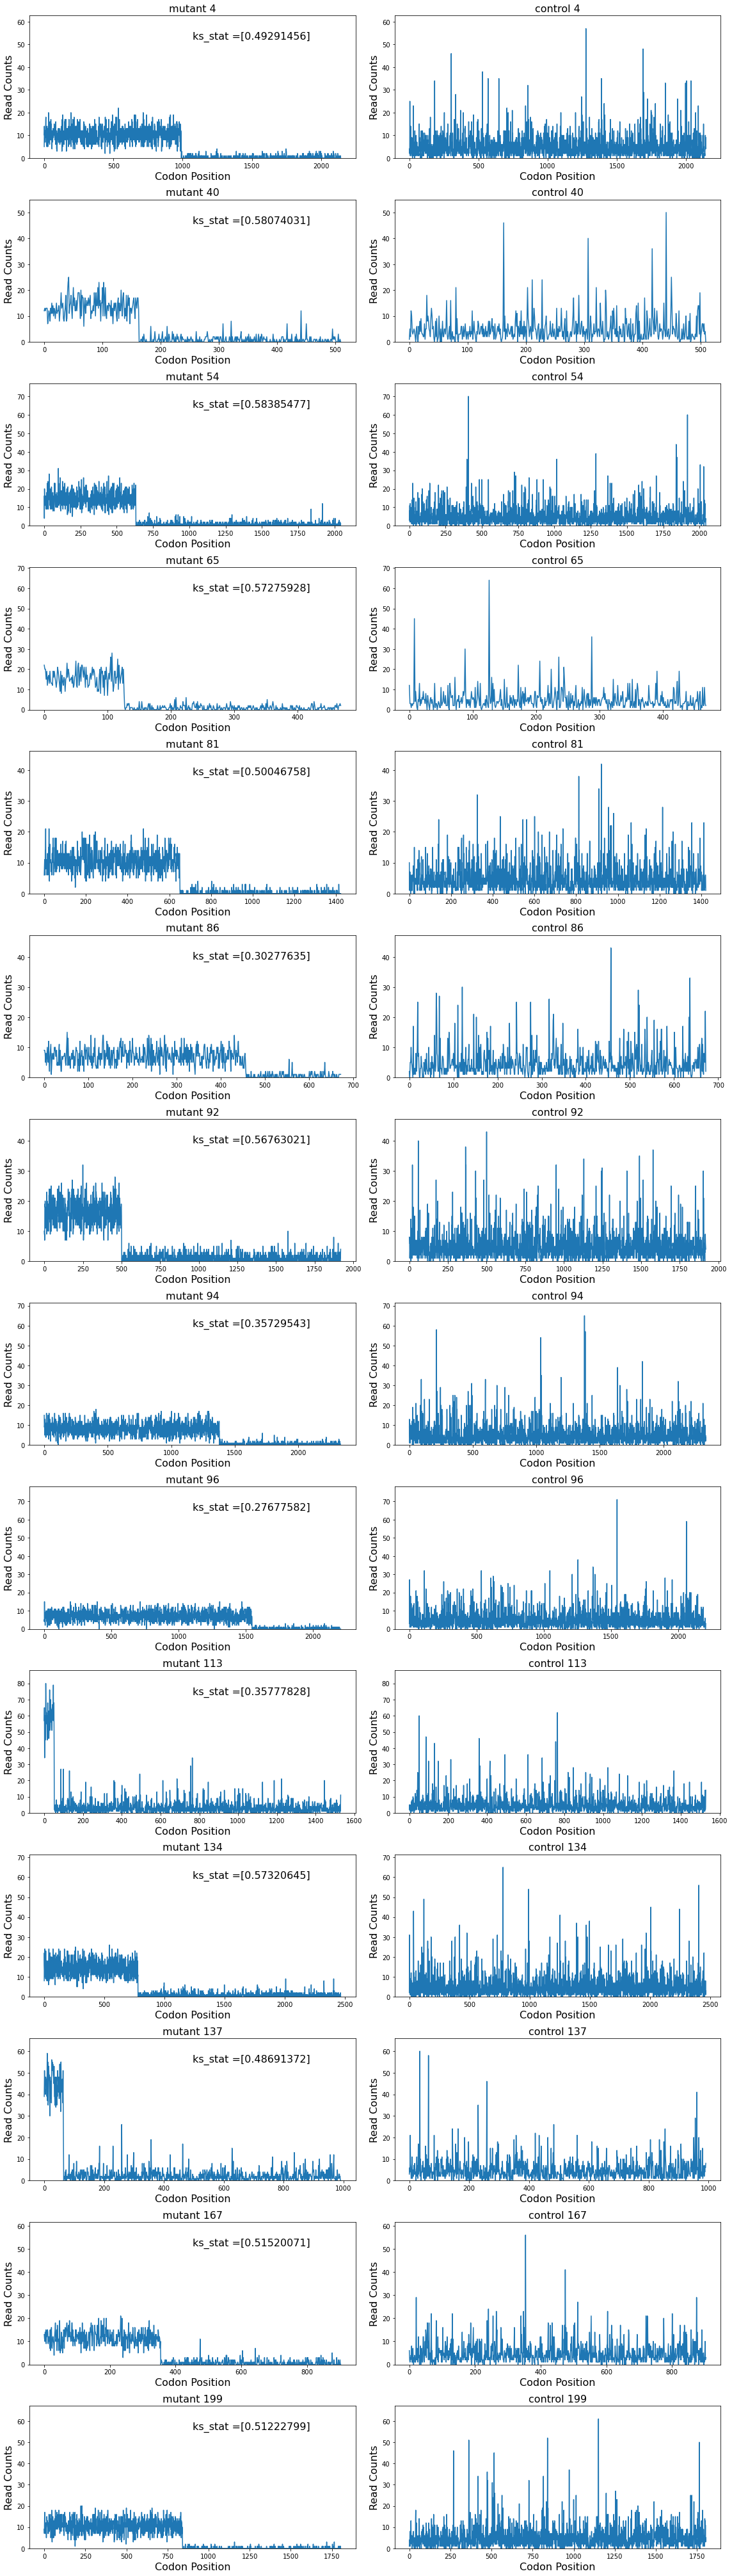

In [64]:
# Look at the smoothed count distributions for each of the transcripts that passed the threshold
ax = big_dif(diff_dist, data_mutant, data_control, figsize = (16,len(diff_dist)*4), fontsize = 16)

## Notes

Get all of the elongation rates from the gamma distribution, then split them up into the original and the mutant. Add noise to the mutant. take 100 of the mutants and put them through the make MC rather than the make LD.

I must ask Khan what the best way to add noise is. Maybe he has some comment on the right amount of noise to add. 

At the moment I am certainly not seeing something similar to what I am getting with the real data. No matter how much noise I add the KS statistic is always going to be similar since it is applied across all the positions equally on average. Are there other things I should randomize? random initiation and termination rates? randomize mean elongation rate? randomize the read density? Should the initiation rates be systematically different in the mutant or randomly different or not different at all? 

Should I take into account the fact that different particle densities caused by different initiation and elongation rates should inherently lead to different read density? Perhaps this could be addressed by somehow multiplying the number of samples taken by the sum of the particle densities

## Experimenting with making a phase diagram showing all point. 

In [46]:
data_control = []
data_mutant = []
alphas = []
mu_alphas = []
betas = []
mu_betas = []
crit_alphas = []
crit_betas = []
crit_mu_alphas = []
crit_mu_betas = []
min_lambs = []
mu_min_lambs = []
ini_lambs = []
mu_ini_lambs = []
for i in range(20):
    length = numpy.random.randint(200,2500)
    alpha = numpy.random.uniform(0.004,0.02)
    x = get_all_intermediates(5.6, 3, length, alpha, 0.05, 5)
    data_control.append(x[0])
    alphas.append(x[1])
    betas.append(x[2])
    crit_alphas.append(x[3])
    crit_betas.append(x[4])
    min_lambs.append(x[5])
    ini_lambs.append(x[6])
    data_mutant.append(x[7])
    mu_alphas.append(x[8])
    mu_betas.append(x[9])
    crit_mu_alphas.append(x[10])
    crit_mu_betas.append(x[11])
    mu_min_lambs.append(x[12])
    mu_ini_lambs.append(x[12])

In [47]:
np.where((np.array(alphas)/np.array(crit_alphas) == np.amax((np.array(alphas)/np.array(crit_alphas)))))

(array([10]),)

Set an arbitrary termination rate (say that termination rate does not have an effect on this process). 

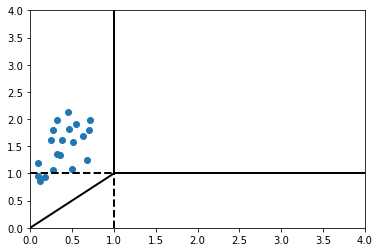

In [65]:
plt.scatter((np.array(alphas)/np.array(crit_alphas)), (np.array(betas)/np.array(crit_betas)))
plt.ylim([0,4])
plt.xlim([0,4])
plt.plot([1, 1], [1, 10], 'k-', lw=2)
plt.plot([1, 10], [1,1], 'k-', lw = 2)
plt.plot([0, 1], [0,1], 'k-', lw = 2)
plt.plot([0, 1], [1,1], 'k--', lw = 2)
plt.plot([1, 1], [0,1], 'k--', lw = 2)

In [470]:
from sympy import symbols, solve, sqrt

In [474]:
def get_critical(alpha, l1, I = 10):
    lmin = symbols('lmin', positive = True, real = True)
    expr = ((l1 - (I-1) * (lmin/((1+sqrt(I))**2))) / 2)*(1 - sqrt(1 - (4*l1*(lmin/((1+sqrt(I))**2)))/((l1 - (I - 1)*(lmin/((1+sqrt(I))**2)))**2))) - alpha
    sol = solve(expr)
    return sol

In [475]:
ini_lambs[14]

3.159413499150265

In [478]:
x = get_critical(alphas[14],ini_lambs[14])

In [481]:
ini_lambs[14]/x[0]

46.5772325180701

What do I need to do this? I need to have the alpha and the Beta value of everything and I need to have the critical alpha and beta value of everything and I need to have the 
minimum elongation rate of everything. 

take the gene with the highest alpha/crit alpha ratio. save the lambda min of that gene. solve the equation of alpha = crit alpha with crit alpha being defined with lambda min as the only variable (other values are made constant). save the new lambda min. SymPy solve function?

Perhaps I should try to organize the things other than the count arrays into a pandas dataframe.

In [ ]:
def get_lmin():
    a = 